In [1]:
sub = pd.read_csv("C:/Users/vppra/Downloads/sample_submission.csv/sample_submission.csv")

### Imports

In [245]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss
from sklearn import linear_model
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt 

In [216]:
train = pd.read_csv("C:/Users/vppra/Downloads/train.csv/train.csv")
test = pd.read_csv("C:/Users/vppra/Downloads/test.csv/test.csv")
test = test.drop(['id'], axis = 1)

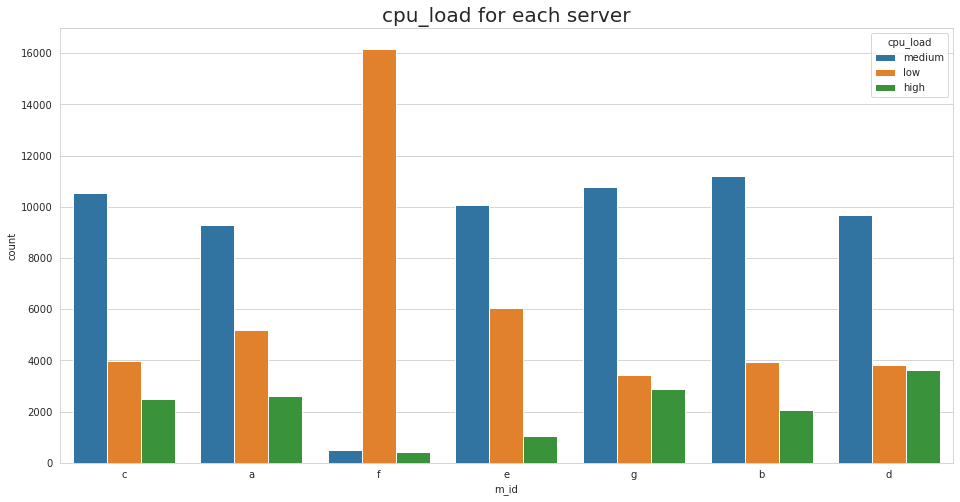

In [177]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(16,8))
plt.title('cpu_load for each server', fontsize=20)
sns.countplot(x='m_id',hue='cpu_load', data = train)
plt.show()

m_id = f clearly has a very high imbalance in the cpu_load.

C:\Users\vppra\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


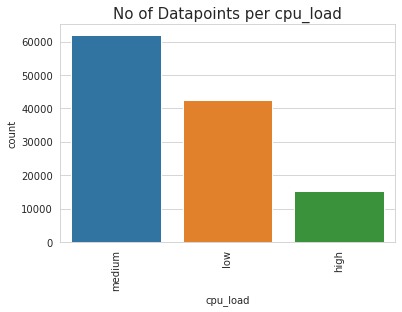

In [178]:
plt.title('No of Datapoints per cpu_load', fontsize=15)
sns.countplot(train.cpu_load)
plt.xticks(rotation=90)
plt.show()

There is a slight imbalance which is close to real-world scenario. Most of the cpu_loads are medium in nature rather than low and high.

In [217]:
#One-hot encoding m_id
col = ['m_id']
train = pd.get_dummies(train,columns = col)
test = pd.get_dummies(test,columns = col)

In [218]:
#Separating into Xtrain and Ytrain.
Xtrain = train.drop(['cpu_load'], axis = 1)
Ytrain = train['cpu_load']

In [10]:
#Feature Selection to remove features 
extc1 = ExtraTreesClassifier(n_estimators=500,max_features= 'sqrt',criterion= 'entropy',class_weight = 'balanced',n_jobs = -1) 
extc1.fit(Xtrain,Ytrain) 

ExtraTreesClassifier(class_weight='balanced', criterion='entropy',
                     max_features='sqrt', n_estimators=500, n_jobs=-1)

In [12]:
importances1 = extc1.feature_importances_
std = np.std([t.feature_importances_ for t in extc1.estimators_],
             axis=0)
indices = np.argsort(importances1)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances1[indices[f]]))

Feature ranking:
1. feature 31 (0.103641)
2. feature 0 (0.095701)
3. feature 1 (0.077034)
4. feature 13 (0.054846)
5. feature 8 (0.034080)
6. feature 4 (0.032894)
7. feature 15 (0.032426)
8. feature 6 (0.027696)
9. feature 9 (0.026659)
10. feature 55 (0.025591)
11. feature 67 (0.024366)
12. feature 34 (0.019683)
13. feature 48 (0.019612)
14. feature 35 (0.019201)
15. feature 10 (0.018588)
16. feature 79 (0.018341)
17. feature 49 (0.018268)
18. feature 80 (0.016401)
19. feature 70 (0.016184)
20. feature 58 (0.015415)
21. feature 71 (0.015386)
22. feature 78 (0.015363)
23. feature 59 (0.015062)
24. feature 81 (0.015056)
25. feature 54 (0.014527)
26. feature 21 (0.013865)
27. feature 91 (0.013824)
28. feature 66 (0.012711)
29. feature 12 (0.009204)
30. feature 33 (0.009051)
31. feature 85 (0.008537)
32. feature 82 (0.008525)
33. feature 83 (0.008410)
34. feature 22 (0.008231)
35. feature 84 (0.008009)
36. feature 19 (0.007429)
37. feature 2 (0.006422)
38. feature 18 (0.006332)
39. feature

In [219]:
#Removing the features with least correlations. 
cols = [25,63,27,24,26,50,68,23,44,87,60,61,32,20,62,38,88,76,75,51,37,30,89,28,39,43,92]
Xtrain.drop(Xtrain.columns[cols],axis=1,inplace=True)
test.drop(test.columns[cols],axis=1,inplace=True)

In [220]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119782 entries, 0 to 119781
Data columns (total 66 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   syst_direct_ipo_rate          119782 non-null  float64
 1   syst_buffered_ipo_rate        119782 non-null  float64
 2   syst_page_fault_rate          119782 non-null  float64
 3   syst_page_read_ipo_rate       119782 non-null  float64
 4   syst_process_count            119782 non-null  int64  
 5   syst_other_states             119782 non-null  int64  
 6   page_page_write_ipo_rate      119782 non-null  float64
 7   page_global_valid_fault_rate  119782 non-null  float64
 8   page_free_list_size           119782 non-null  int64  
 9   page_modified_list_size       119782 non-null  int64  
 10  io_mailbox_write_rate         119782 non-null  float64
 11  io_split_transfer_rate        119782 non-null  float64
 12  io_file_open_rate             119782 non-nul

In [71]:
'''e = Xtrain[['tcp_in' 
   ,'tcp_out' 
   ,'tcp_rxdup'
   ,'tcp_kpalv','page_free_list_faults','page_modified_list_faults','page_demand_zero_faults']]
e.corr()
'''

,tcp_in,tcp_out,tcp_rxdup,tcp_kpalv,page_free_list_faults,page_modified_list_faults,page_demand_zero_faults
tcp_in,1.000000,0.968412,-0.002005,-0.001371,0.368015,0.282496,0.217299
tcp_out,0.968412,1.000000,-0.009088,-0.000039,0.377219,0.318457,0.256232
tcp_rxdup,-0.002005,-0.009088,1.000000,0.012271,0.004055,-0.006931,0.002248
tcp_kpalv,-0.001371,-0.000039,0.012271,1.000000,0.003983,-0.000743,-0.000486
page_free_list_faults,0.368015,0.377219,0.004055,0.003983,1.000000,0.466743,0.348212
page_modified_list_faults,0.282496,0.318457,-0.006931,-0.000743,0.466743,1.000000,0.821861
page_demand_zero_faults,0.217299,0.256232,0.002248,-0.000486,0.348212,0.821861,1.000000


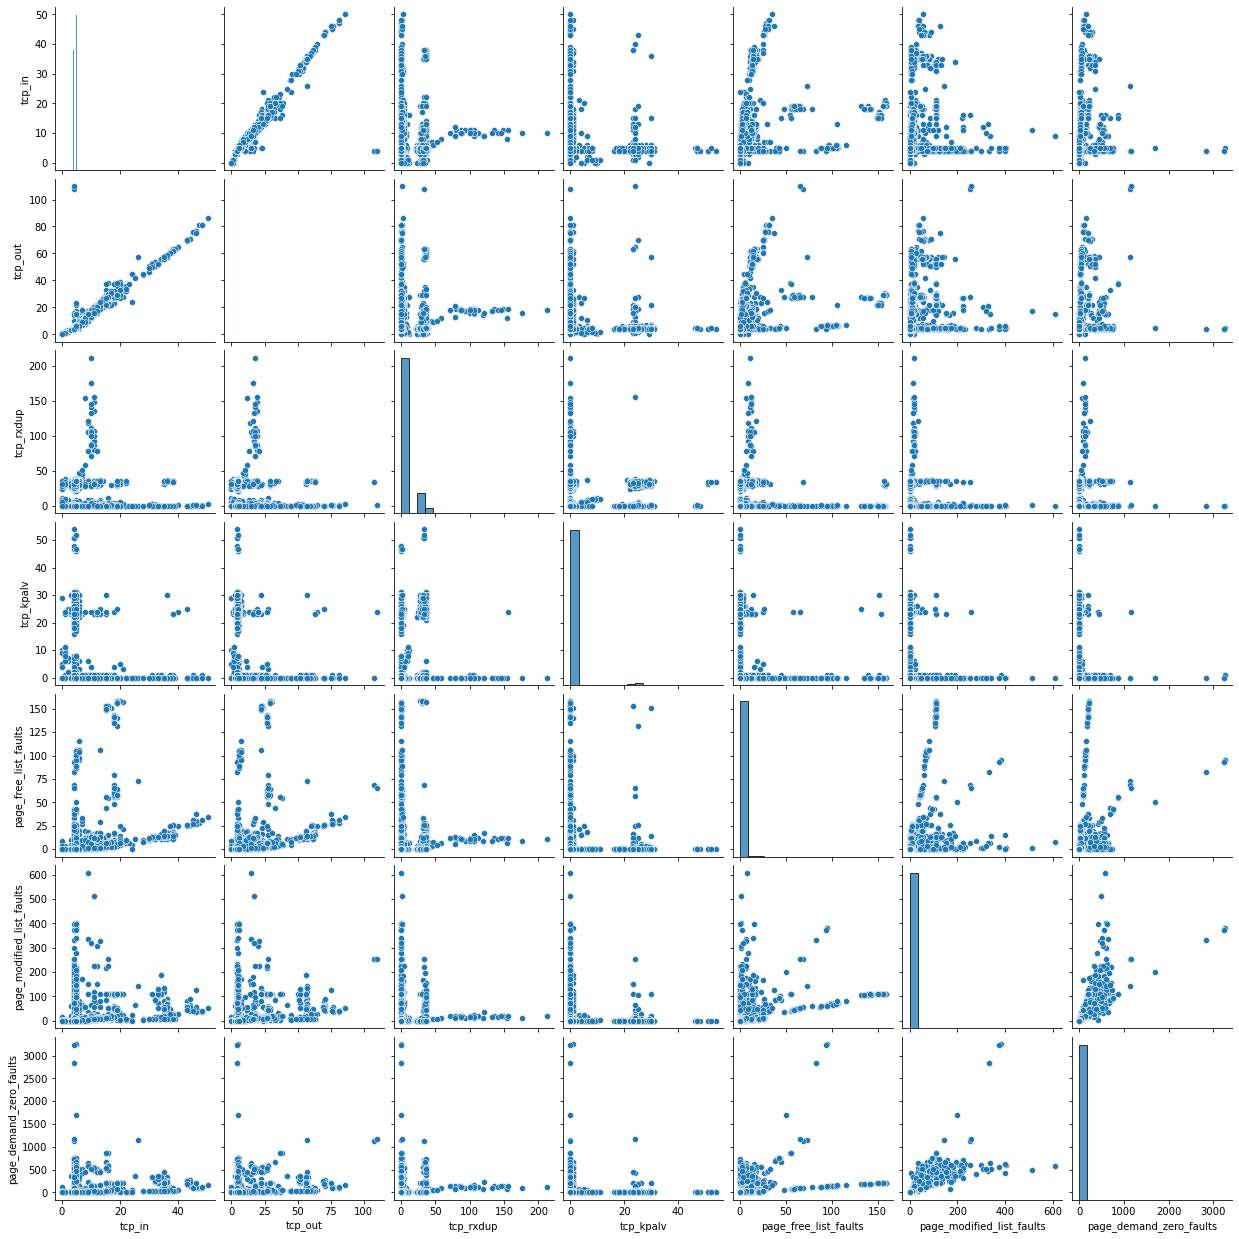

In [23]:
#sns.pairplot(e)

##### tcp_in and tcp_out are positively correlated with each other. So, we drop one of them which has highest correlation with cpu_load.

In [222]:
Xtrain['page_list_faults'] = Xtrain[['page_modified_list_faults', 'page_demand_zero_faults']].mean(axis=1)
test['page_list_faults'] = test[['page_modified_list_faults', 'page_demand_zero_faults']].mean(axis=1)

In [223]:
Xtrain['page_list_faults'] = [0 if x == 0 else 1 for x in Xtrain['page_list_faults']]
Xtrain['page_free_list_faults'] = [0 if x == 0 else 1 for x in Xtrain['page_free_list_faults']]
Xtrain['tcp_rxdup'] = [0 if x == 0 else 1 for x in Xtrain['tcp_rxdup']]
test['page_list_faults'] = [0 if x == 0 else 1 for x in test['page_list_faults']]
test['page_free_list_faults'] = [0 if x == 0 else 1 for x in test['page_free_list_faults']]
test['tcp_rxdup'] = [0 if x == 0 else 1 for x in test['tcp_rxdup']]
#Feature Binning - Converting numerical features into categorical features.

In [224]:
Xtrain.drop(['page_demand_zero_faults','page_modified_list_faults','tcp_rxdup','tcp_kpalv'],axis = 1)
test.drop(['page_demand_zero_faults','page_modified_list_faults','tcp_rxdup','tcp_kpalv'],axis = 1)

,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,...,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec,m_id_a,m_id_e,m_id_f,page_list_faults
0,30.20,335.77,0.00,0.00,165,10,0.00,0.00,280348,40113,...,0.717,0.017,229.117,375.250,272.233,201.167,0,0,1,0
1,75.30,665.08,30.33,4.53,271,12,9.83,13.45,135805,101499,...,67.817,89.483,666.533,554.267,496.233,387.850,1,0,0,1
2,31.02,251.00,0.00,0.00,259,22,0.38,0.00,171796,60556,...,15.483,20.767,229.800,220.300,315.483,277.767,0,0,0,0
3,38.78,493.92,0.05,0.00,252,10,7.65,0.05,172948,67821,...,25.033,34.550,302.733,230.600,308.483,273.650,0,1,0,0
4,62.83,379.27,0.00,0.00,318,10,0.27,0.00,88866,93458,...,66.050,93.083,226.067,331.033,228.017,233.450,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58993,33.08,502.40,0.00,0.00,217,2,2.75,0.00,195428,57828,...,20.033,27.450,539.867,482.433,547.783,719.567,0,0,0,0
58994,90.98,617.57,27.78,4.37,317,10,0.57,9.15,90446,93435,...,68.467,96.983,236.050,432.133,329.567,243.833,0,0,0,1
58995,37.90,343.73,0.55,0.00,258,22,4.85,0.00,171923,60614,...,15.767,21.117,229.233,143.467,341.933,214.417,0,0,0,1
58996,60.68,686.57,0.02,0.00,317,10,16.97,0.00,95154,92797,...,65.217,91.467,309.700,316.983,294.383,281.450,0,0,0,1


In [225]:
Xtrain['syst_page_fault_rate'] = [0 if x == 0 else 1 for x in Xtrain['syst_page_fault_rate']]
Xtrain['page_free_list_faults'] = [0 if x == 0 else 1 for x in Xtrain['page_free_list_faults']]
Xtrain['tcp_rxdup'] = [0 if x == 0 else 1 for x in Xtrain['tcp_rxdup']]
Xtrain['app08_pagesproc'] = [0 if x == 0 else 1 for x in Xtrain['app08_pagesproc']]
Xtrain['syst_page_read_ipo_rate'] = [0 if x == 0 else 1 for x in Xtrain['syst_page_read_ipo_rate']]
Xtrain['io_split_transfer_rate'] = [0 if x == 0 else 1 for x in Xtrain['io_split_transfer_rate']]

test['syst_page_fault_rate'] = [0 if x == 0 else 1 for x in test['syst_page_fault_rate']]
test['page_free_list_faults'] = [0 if x == 0 else 1 for x in test['page_free_list_faults']]
test['tcp_rxdup'] = [0 if x == 0 else 1 for x in test['tcp_rxdup']]
test['app08_pagesproc'] = [0 if x == 0 else 1 for x in test['app08_pagesproc']]
test['syst_page_read_ipo_rate'] = [0 if x == 0 else 1 for x in test['syst_page_read_ipo_rate']]
test['io_split_transfer_rate'] = [0 if x == 0 else 1 for x in test['io_split_transfer_rate']]

In [53]:
extc2 = ExtraTreesClassifier(n_estimators=500,max_features= 'sqrt',criterion= 'entropy',class_weight = 'balanced',n_jobs = -1) 
extc2.fit(Xtrain,Ytrain) 

ExtraTreesClassifier(class_weight='balanced', criterion='entropy',
                     max_features='sqrt', n_estimators=500, n_jobs=-1)

In [54]:
importances2 = extc2.feature_importances_
std = np.std([t.feature_importances_ for t in extc2.estimators_],
             axis=0)
indices = np.argsort(importances2)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances2[indices[f]]))

Feature ranking:
1. feature 25 (0.101078)
2. feature 0 (0.091735)
3. feature 1 (0.078634)
4. feature 13 (0.061171)
5. feature 4 (0.036122)
6. feature 8 (0.030848)
7. feature 15 (0.030336)
8. feature 6 (0.026715)
9. feature 53 (0.025481)
10. feature 45 (0.025329)
11. feature 9 (0.023398)
12. feature 44 (0.020940)
13. feature 10 (0.020334)
14. feature 28 (0.019354)
15. feature 39 (0.019154)
16. feature 62 (0.018984)
17. feature 40 (0.018976)
18. feature 27 (0.018246)
19. feature 56 (0.016188)
20. feature 72 (0.015871)
21. feature 61 (0.015752)
22. feature 64 (0.015372)
23. feature 55 (0.014894)
24. feature 49 (0.014730)
25. feature 48 (0.014604)
26. feature 63 (0.014276)
27. feature 52 (0.011357)
28. feature 20 (0.011037)
29. feature 12 (0.009080)
30. feature 65 (0.008899)
31. feature 68 (0.008880)
32. feature 66 (0.008812)
33. feature 11 (0.008561)
34. feature 67 (0.008460)
35. feature 26 (0.008251)
36. feature 21 (0.008206)
37. feature 19 (0.007792)
38. feature 75 (0.005687)
39. featur

In [257]:
test.head()

,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,...,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec,m_id_a,m_id_e,m_id_f,page_list_faults
0,30.20,335.77,0,0,165,10,0.00,0.00,280348,40113,...,0.717,0.017,229.117,375.250,272.233,201.167,0,0,1,0
1,75.30,665.08,1,1,271,12,9.83,13.45,135805,101499,...,67.817,89.483,666.533,554.267,496.233,387.850,1,0,0,1
2,31.02,251.00,0,0,259,22,0.38,0.00,171796,60556,...,15.483,20.767,229.800,220.300,315.483,277.767,0,0,0,0
3,38.78,493.92,1,0,252,10,7.65,0.05,172948,67821,...,25.033,34.550,302.733,230.600,308.483,273.650,0,1,0,0
4,62.83,379.27,0,0,318,10,0.27,0.00,88866,93458,...,66.050,93.083,226.067,331.033,228.017,233.450,0,0,0,0


Feature Grouping to check the correlation between the features and drop the ones with the highest correlation within themselves.

In [261]:
tcp = Xtrain[['tcp_in'                         
   ,'tcp_out'                        
   ,'tcp_rxdup']]
tcp.corr().unstack().sort_values().drop_duplicates()

tcp_in   tcp_rxdup    0.012191
tcp_out  tcp_rxdup    0.023468
tcp_in   tcp_out      0.968412
         tcp_in       1.000000
dtype: float64

#### Example. Experimented around for all appxxxx, pagexxx, syst_xxx ,state_xxx ,io_xxx,tcp_xxx,llxxx, ewxxx

In [ ]:

e = data[['app06_dirio' 
   ,'app06_bufio' 
   ,'app06_pgflts'
   ,'app06_proccount' 
   ,'app06_pagesgbl'
   ,'app06_pagesproc']]
print(e.value_counts())
print(e.corr().unstack().sort_values().drop_duplicates())

In [81]:
'''from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(Xtrain, Ytrain,test_size = 0.30,stratify = Ytrain)
print('Train data:', X_train.shape)
print('Cross Validation data:', X_cv.shape)'''

Train data: (83847, 76)
Cross Validation data: (35935, 76)


In [256]:
'''alpha = [100,200,500,1000,2000]
max_depth = [5, 10,15,20]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
        '''

'alpha = [100,200,500,1000,2000]\nmax_depth = [5, 10,15,20]\ncv_log_error_array = []\nfor i in alpha:\n    for j in max_depth:\n        print("for n_estimators =", i,"and max depth = ", j)\n        clf = RandomForestClassifier(n_estimators=i, criterion=\'gini\', max_depth=j, random_state=42, n_jobs=-1)\n        clf.fit(X_train, y_train)\n        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")\n        sig_clf.fit(X_train, y_train)\n        sig_clf_probs = sig_clf.predict_proba(X_cv)\n        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))\n        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) \n        '

In [160]:
X_train['syst_process_count'].describe()
#Feature Binning could be done into 4 categories : >165 & <217, >217 & <247, >247 & <271, >323

count    83847.000000
mean       243.958007
std         43.481801
min        165.000000
25%        217.000000
50%        247.000000
75%        271.000000
max        323.000000
Name: syst_process_count, dtype: float64

### function for a generalized model.

In [122]:
from datetime import datetime
def perform_model(model, Xtrain, Ytrain, test):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(Xtrain, Ytrain)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict_proba(test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    
    #add the trained  model to the results
    results['model'] = model
    
    return results
    
    

### Function to get the best hyperparameters 

In [123]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('|      Best Estimator     |')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('|     Best parameters     |')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))

#### Logistic Regression as the baseline model.

In [125]:
# start Grid search
parameters = {'C':[0.01, 0.1, 1, 10, 20]}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results =  perform_model(log_reg_grid, Xtrain, Ytrain, test)


training the model..
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.8s finished


Done 
 

training_time(HH:MM:SS.ms) - 0:00:14.503435


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.057846




In [128]:
# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])

|      Best Estimator     |

	LogisticRegression(C=0.01)

|     Best parameters     |
	Parameters of best estimator : 

	{'C': 0.01}

|   No of CrossValidation sets   |

	Total number of cross validation sets: 3

|        Best Score       |

	Average Cross Validate scores of best estimator : 

	0.3873475204500266



### Hyperparameter tuning for RF

#### Random Forests : Used RandomizedSearchCV to tune hyperparameters iteratively. 

1. learning_rate = 0.1
2. n_estimators= 512
3. min_samples_split = 1200
4. min_samples_leaf = 20
5. max_features = 12
6. max_depth = 12
7. subsample = 0.85

In [255]:
'''from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': np.arange(100,400,20)}
rfc = RandomForestClassifier()
rfc_grid = RandomizedSearchCV(rfc, param_grid=params, n_jobs=-1)
rfc_grid_results = perform_model(rfc_grid, Xtrain, Ytrain, test)
print_grid_search_attributes(rfc_grid_results['model'])
'''

"from sklearn.ensemble import RandomForestClassifier\nparams = {'n_estimators': np.arange(100,400,20)}\nrfc = RandomForestClassifier()\nrfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)\nrfc_grid_results = perform_model(rfc_grid, Xtrain, Ytrain, test)\nprint_grid_search_attributes(rfc_grid_results['model'])\n"

In [265]:
'''param_gb = {
                'learning_rate': [0.01,0.1,0.2,0.5]
                'n_estimators': [100,200,500,600,1000,1200,1500,2000]
                'max_features': [3, 5, 7, 12,16,24,30],
                'max_depth': [3, 5, 10,20,25,30], 
                'min_samples_split': [2 ** x for x in range(1, 12)],
                'min_samples_leaf': [1,3,7,15],
             }

grid_gb = GridSearchCV(GradientBoostingClassifier(), param_gb, cv = 5)
grid_gb.fit(Xtrain, Ytrain)
'''

"param_gb = {\n                'learning_rate': [0.01,0.1,0.2,0.5]\n                'n_estimators': [100,200,500,600,1000,1200,1500,2000]\n                'max_features': [3, 5, 7, 12,16,24,30],\n                'max_depth': [3, 5, 10,20,25,30], \n                'min_samples_split': [2 ** x for x in range(1, 12)],\n                'min_samples_leaf': [1,3,7,15],\n             }\n\ngrid_gb = GridSearchCV(GradientBoostingClassifier(), param_gb, cv = 5)\ngrid_gb.fit(Xtrain, Ytrain)\n"

In [165]:
from sklearn.ensemble import GradientBoostingClassifier
clf2 = GradientBoostingClassifier(learning_rate = 0.1,n_estimators=500,min_samples_split = 1200,min_samples_leaf=20,max_features=12,max_depth = 12,subsample=0.85,random_state=42,verbose = 1)
clf2.fit(Xtrain, Ytrain)
y_pred2 = clf2.predict_proba(test)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8393           0.1310           14.46m
         2           0.7423           0.0964           14.85m
         3           0.6658           0.0754           14.96m
         4           0.6070           0.0592           14.83m
         5           0.5552           0.0506           14.73m
         6           0.5116           0.0425           14.69m
         7           0.4765           0.0352           14.62m
         8           0.4443           0.0318           14.58m
         9           0.4164           0.0277           14.51m
        10           0.3911           0.0243           14.48m
        20           0.2665           0.0067           14.42m
        30           0.2241           0.0023           14.42m
        40           0.2041           0.0007           14.32m
        50           0.1920           0.0005           14.34m
        60           0.1833           0.0001           14.12m
       

In [166]:
submission16 = pd.DataFrame(y_pred2, columns=clf2.classes_)
submission16['id'] = submission16.index
submission16 = submission16[['id', 'low', 'medium', 'high']]
submission16.to_csv('C:/Users/vppra/Downloads/sample_submission.csv/submission16.csv',index=False)

Log loss = 0.20369

In [167]:
from sklearn.ensemble import GradientBoostingClassifier
clf3 = GradientBoostingClassifier(learning_rate = 0.05,n_estimators=1000,min_samples_split = 1200,min_samples_leaf=20,max_features=12,max_depth = 12,subsample=0.85,random_state=42,verbose = 1)
clf3.fit(Xtrain, Ytrain)
y_pred3 = clf3.predict_proba(test)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9026           0.0674           32.49m
         2           0.8450           0.0575           32.42m
         3           0.7945           0.0500           31.99m
         4           0.7515           0.0438           31.98m
         5           0.7109           0.0396           31.63m
         6           0.6743           0.0357           31.53m
         7           0.6423           0.0322           31.41m
         8           0.6123           0.0297           31.16m
         9           0.5847           0.0279           31.00m
        10           0.5588           0.0253           30.87m
        20           0.3931           0.0111           31.32m
        30           0.3122           0.0060           31.15m
        40           0.2674           0.0031           31.06m
        50           0.2416           0.0019           30.83m
        60           0.2242           0.0009           30.91m
       

Logloss = 0.20254

In [168]:
submission17 = pd.DataFrame(y_pred3, columns=clf3.classes_)
submission17['id'] = submission17.index
submission17 = submission17[['id', 'low', 'medium', 'high']]
submission17.to_csv('C:/Users/vppra/Downloads/sample_submission.csv/submission17.csv',index=False)

In [185]:
#clf4 = HistGradientBoostingClassifier(loss = 'categorical_crossentropy', learning_rate = 0.1,max_iter=300,min_samples_leaf=20,max_depth = 12,l2_regularization = 0.4,random_state=42,verbose = 1)
#clf4.fit(Xtrain, Ytrain)
#y_pred4 = clf4.predict_proba(test)

Attempted Stacking Classifier with layer 0 estimators : Random Forests and Gradient Boosting. Layer 1, Metaclassifier : Logistic Regression.

In [196]:
#from sklearn.ensemble import StackingClassifier
#from sklearn.linear_model import LogisticRegression

#### Hyperparameter Tuned Random Forests. 

In [247]:
rf_clf = RandomForestClassifier(criterion = 'entropy', n_estimators = 750,max_depth=20,max_features=28,n_jobs=-1,verbose=1)

In [248]:
rf_clf.fit(Xtrain,Ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  8.1min finished


RandomForestClassifier(criterion='entropy', max_depth=20, max_features=28,
                       n_estimators=750, n_jobs=-1, verbose=1)

In [249]:
y_predrf = rf_clf.predict_proba(test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    4.3s finished


In [250]:
submission23 = pd.DataFrame(y_predrf, columns=rf_clf.classes_)
submission23['id'] = submission23.index
submission23 = submission23[['id', 'low', 'medium', 'high']]
submission23.to_csv('C:/Users/vppra/Downloads/sample_submission.csv/submission23.csv',index=False)

### Log Loss for Submission 23 : RandomForests= 0.205 <br> 
### Log Loss for Submission Gradient Boosting clf3 = 0.202

In [240]:
#estimators = [('gb',clf3),('rf', rf_clf)]
#clf = StackingClassifier(estimators,final_estimator = lr, cv = 3, stack_method = 'predict_proba',n_jobs = -1,verbose = 1)

In [241]:
#clf.fit(Xtrain, Ytrain)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 15 epochs took 1 seconds
convergence after 17 epochs took 1 seconds
convergence after 18 epochs took 1 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


StackingClassifier(cv=3,
                   estimators=[('gb', RandomForestClassifier()),
                               ('rf',
                                RandomForestClassifier(max_depth=16,
                                                       max_features=25,
                                                       min_samples_split=40,
                                                       n_estimators=500,
                                                       n_jobs=-1, verbose=1))],
                   final_estimator=LogisticRegression(C=0.2, max_iter=300,
                                                      multi_class='ovr',
                                                      n_jobs=-1,
                                                      random_state=42,
                                                      solver='saga',
                                                      verbose=1),
                   n_jobs=-1, stack_method='predict_proba', verbose=1)

In [242]:
#ypredS = clf.predict_proba(test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.6s finished


StackingClassifier has given unsatisfactory logloss accuracy. Aggregation of both the models when the meta classifier is logistic regression has done a poor job. 

In [243]:
'''submission21 = pd.DataFrame(ypredS, columns=clf.classes_)
submission21['id'] = submission21.index
submission21 = submission21[['id', 'low', 'medium', 'high']]
submission21.to_csv('C:/Users/vppra/Downloads/sample_submission.csv/submission21.csv',index=False)'''

### VotingClassifier on Gradient Boosting and Random Forests with the following hyperparameters. 

Output accuracy will be more for voting = 'soft' as it is the average probability of the all estimators combined.

In [254]:
vc = VotingClassifier(estimators=[('gb',clf2),('rf', rf_clf)], voting='soft',n_jobs= -1,verbose=True)
vc.fit(Xtrain, Ytrain)
#y_val_pred = eclf.predict_proba(test)

MemoryError: 

#### MemoryError on local. When tried on a higher machine with better RAM, achieved a logloss score of 0.19768. 

In [271]:
FinalScoreSubmission = pd.read_csv("C:/Users/vppra/Downloads/submission21.csv")
FinalScoreSubmission

,id,low,medium,high
0,0,0.996281,0.003580,0.000139
1,1,0.030682,0.969102,0.000216
2,2,0.998960,0.000948,0.000092
3,3,0.821896,0.177857,0.000247
4,4,0.999239,0.000742,0.000018
...,...,...,...,...
58993,58993,0.043458,0.956048,0.000494
58994,58994,0.173231,0.783091,0.043678
58995,58995,0.906166,0.092864,0.000969
58996,58996,0.000956,0.998217,0.000828


### Conclusion: 

#### Feature Engineering :
Used ExtraTreesClassifier to find the feature importance, Correlation amongst similar groups. Dropped low importance features, converted numerical features into categorical features (0 if 0 else 1), feature binning and interaction variables. <br>

#### Hyperparameter tuning and crossvalidation : 
Experimented around with GridSearchCV, RandomizedSearchCV, CalibratedSearchCV <br>

#### Models tried : 
    Logistic Regression
    Decision Tree Classifier
    Random Forests Classifier
    Gradient Boosting Classifier
    Hist Gradient Boosting Classifier
    Stacking Classifier 
    Voting Classifier 
    

#### Models which gave best logloss accuracy :

Ensembling model VotingClassifier with 2 hyperparameter tuned models - Random Forest Classifier and Gradient Boosting Classifier. 